# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPdfdfdRjJXXXXX' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcdfdfdjD3dKBe682Yt2MOiNv6bXXXX' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24dfdfdfvBgwXKyPi5bXXXX' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEdfdfdfYDS9VfIzOboQoXXXX'<br />

## Modulo para autenticação no twitter

In [1]:
!ls *.txt

dados.txt               tokens.txt
stopwords-portugues.txt tokes.txt


In [ ]:
!pip install -q twitter
!pip install -q pymongo

In [2]:
!cat tokens.txt

DcPtlOYZ07jilc3PgYJLUPRjJ
bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b
2904474861-qPmMjcwisBQWR1cMILoXevC8QeKS3Go3PzN5lBq
h0iaWqpk7YqsP9MAk5mU472ZOsFOtunfL76fwhEY3x9PA

## Leitura das chaves de acesso

In [3]:
def ler_tokens_acesso():
    filename = 'tokens.txt'
    with open(filename) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    return content[0], content[1], content[2], content[3]

#CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
#print(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# Twitter

In [4]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    #CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUdfdfdfJ'
    #CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOdfdf'
    
    #OAUTH_TOKEN = '2904474861-hJHuW0Q1TGSUjOFvlgqU4ZFYvPCDO214aILxR5L'
   # OAUTH_TOKEN_SECRET = 'aBCJrbhXVEBgZ7gKo9yCNUMjlierefMkY43rZEvXK9BFI'
    
    CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [5]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [ ]:
#!pip install -q pymongo

In [ ]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [6]:
%%time

q = ''
q = ''
q = 'furacao ian'
q = 'terremoto equador'
q = 'rmr'
result = twitter_search(twitter_api, q, max_results=5000)
type(result)

CPU times: user 326 ms, sys: 72.6 ms, total: 399 ms
Wall time: 19.5 s


list

In [7]:
len(result)

1042

In [8]:
result

[{'created_at': 'Fri Apr 07 15:57:10 +0000 2023',
  'id': 1644368728782503936,
  'id_str': '1644368728782503936',
  'text': 'RMR is a fucking vibe, we need more Majors in CS2 moving forward; atleast three every year!',
  'truncated': False,
  'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 2231844955,
   'id_str': '2231844955',
   'name': 'Hassan Abdullah',
   'screen_name': 'NightWing94',
   'location': 'Abu Dhabi',
   'description': 'Used to Play Overwatch/TF2/CSGO, now im just washed up, worked for @Arab_eSports, @Gaming420  co-founder @pakcord (tf2/csgo earlier) Proud 🇵🇰 based in 🇦🇪',
   'url': 'https://t.co/AMG7BYL

In [20]:
result2 = []
for i in range(len(result)):
    if result[i]['lang'] == 'pt':
        result2.append(result[i])
print(len(result2))    

304


In [9]:
result[4]

{'created_at': 'Fri Apr 07 15:55:36 +0000 2023',
 'id': 1644368335843328005,
 'id_str': '1644368335843328005',
 'text': '@Joao_CRF81 Hoje as 16h &gt; CS no RMR pra vaga no Major ! Jogo muito difícil contra o time 6 no ranking mundial, mas… https://t.co/H8CijRtRTD',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Joao_CRF81',
    'name': 'João #ForaMarcosBraz',
    'id': 1468744735,
    'id_str': '1468744735',
    'indices': [0, 11]}],
  'urls': [{'url': 'https://t.co/H8CijRtRTD',
    'expanded_url': 'https://twitter.com/i/web/status/1644368335843328005',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [119, 142]}]},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': 1644367625659580417,
 'in_reply_to_status_id_str': '1644367625659580417',
 'in_reply_to_user_id': 1468744735,
 

In [10]:
tweet = result[4]['text']
data = result[4]['created_at']
data, tweet

('Fri Apr 07 15:55:36 +0000 2023',
 '@Joao_CRF81 Hoje as 16h &gt; CS no RMR pra vaga no Major ! Jogo muito difícil contra o time 6 no ranking mundial, mas… https://t.co/H8CijRtRTD')

In [15]:
for i in range(20):  
    if result[i]['lang'] == 'pt':
        tweet = result[i]['text']
        data = result[i]['created_at']
        #print(data, ':', tweet)
        print(tweet)

@Joao_CRF81 Hoje as 16h &gt; CS no RMR pra vaga no Major ! Jogo muito difícil contra o time 6 no ranking mundial, mas… https://t.co/H8CijRtRTD
RT @rpesteves: A malta que se queixa de perder no RMR não se lembra de quando nem dos qualificadores abertos passávamos. 😂
RT @gamearenaofc: Bora de agenda do fim de semana?! 📝

Feriadou com muito CS e Brasil no RMR Américas!

Anota aí que o @filipe_carbone trou…
@lucaxstt eles quasem aposentaram o Fallen no rmr passado KKKKKKKKKKKKKKKKK espero que eles tomem pica dnv pra sumirem da Los
Bora de agenda do fim de semana?! 📝

Feriadou com muito CS e Brasil no RMR Américas!

Anota aí que o… https://t.co/J4xD0s1cAl
@lucaxstt Pqp eu tbm tava pensando isso no rmr passado kkkkkkkkk
RT @B24Esports: O sonho não foi possível.

SAW não consegue o apuramento para o Major após três derrotas no RMR. https://t.co/W0lo3U17c3


In [ ]:
len(result)

In [ ]:
#results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(result, 'tweets2023', q)

In [ ]:
%%time

q = ''
q = 'terremoto equador'
twitter_api = oauth_login()
results = []
for i in range(2):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
print("Numero de tweets capturados: ", len(results))

results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(results, 'tweets', q)

In [ ]:
results[0] 

In [ ]:
results[2]['created_at']

In [ ]:
results[2]['metadata']['iso_language_code']

In [ ]:
len(results)

## imprimindo tweets

In [ ]:
#result = results
i = 0
for tweet in result:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

## Nuvem de Palavras - tweet

### Stopwords

In [16]:
# instalando o módulo de stopwords
!pip install -q stop-words
results = result

In [17]:
from stop_words import get_stop_words

stop_words_portugues = get_stop_words('pt')
print(stop_words_portugues)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

In [18]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')

#stop_words_portugues
stop_words_portugues = get_stop_words('pt')


#stop_words
stop_words = stop_words_english + stop_words_portugues

print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [ ]:
#!pip install wordcloud

In [ ]:
type(result)

In [ ]:
result[5]

93500


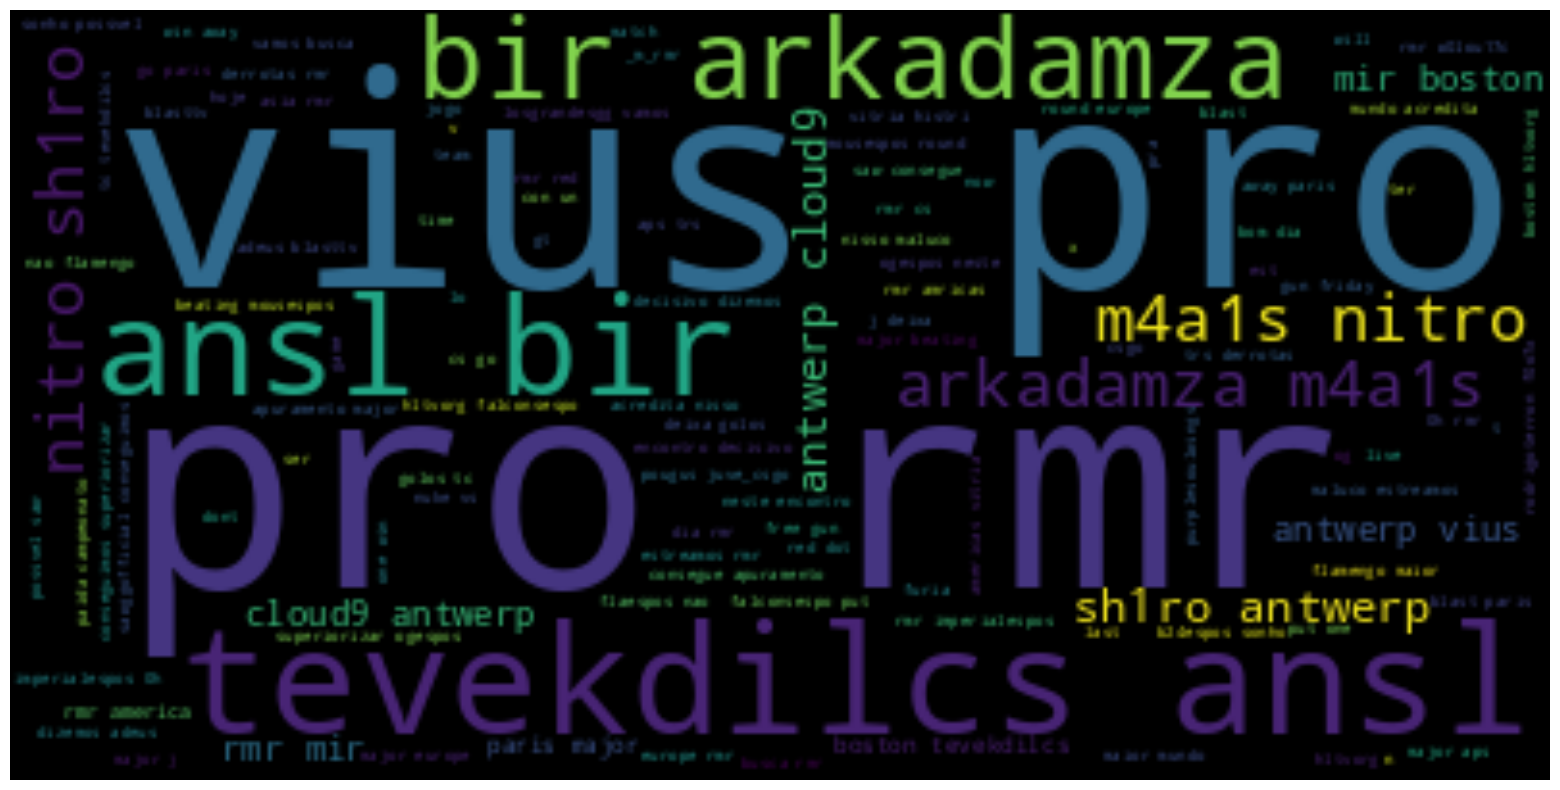

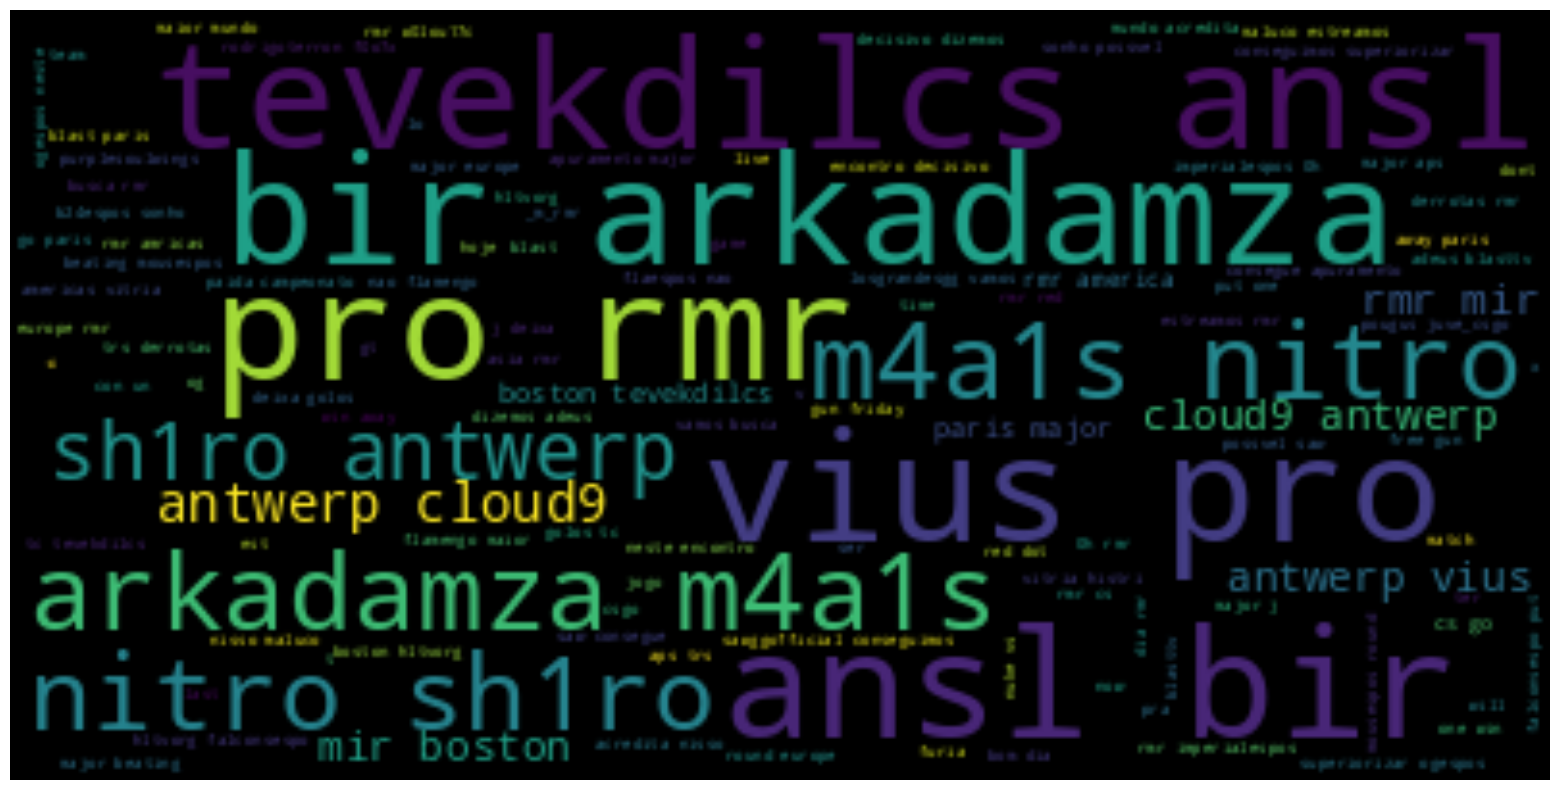

In [21]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text'] + ' '
        
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")
stext = stext.replace("tco","")
stext = stext.replace("rt","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [22]:
words = stext.split()

In [24]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:100]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

rmr
antwerp
2022
pro
20
bir
vius
2020
tevekdilcs:
ansl
arkadamza
m4a1s
nitro
(sh1ro
cloud9
mir
boston
major
paris
americas
vs
flamengo
dia
saw
blasttv
cs:go
j
202
vitria
nao
time
hltvorg:
vamos
blast
21
europe
tc
flaespos:
mundo
acredita
win
maior
nisso
maluco
estreamos
histri
viuspro
pra
2
b24espos:
t
1
sonho
aps
blastpremier
first
busca
161
un
el
hoje
amricas
one
10
con
sproutgg
nuke
losgrandesgg:
imperialespos
vai
mibr
go
round
derrotas
live
11
18:0h
deixa
golos
&gt;
los
possvel
consegue
apuramento
trs
/w0lou17c
just
ogespos
team
jogo
contra
day
sawggofficial
estreia
s
12
bom
yur
venceu
en


In [ ]:
for i in range(15):
    print (c.popitem())

## colocando as palavras e suas frequencias do twitter num dataframe

In [ ]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [ ]:
place = []
results = result.copy()
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

In [ ]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

In [ ]:
for i in range(15):
    print(location.pop())

## contar a ocorrencia de cada cidade

In [ ]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [ ]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [ ]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [ ]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

In [ ]:
len(tweets_com_coordenadas)/len(results) * 100

In [ ]:
tweets_com_coordenadas[0]['place']['bounding_box']

In [ ]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

In [ ]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

In [ ]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [ ]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

In [ ]:
len(tweets_com_coordenadas)

In [ ]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [ ]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

In [ ]:
print(list(latitudes_tweets[:15]))

In [ ]:
print(list(longitudes_tweets[:15]))

In [ ]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

In [ ]:
len(df10)

In [ ]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

In [ ]:
df11.to_csv('coordenadas-tweets.csv', index=False)

In [ ]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets.csv')
df11.head()

In [ ]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

In [ ]:
print(list(latitudes_tweets[:10]))

In [ ]:
print(list(longitudes_tweets[:10]))

## ler coordenadas de um arquivo

In [ ]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

In [ ]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

## remover tuplas duplicadas

In [ ]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

# Georeferenciar os tweets no mapa mundi

In [ ]:
#!pip install -q folium

In [ ]:
tweets_coordenadasXY

In [ ]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'


folium.Map.save(mapit, "index.html")


mapit

# twitter trends - assuntos mais comentados do momento

In [ ]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [ ]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [ ]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

In [ ]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

In [ ]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

In [ ]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

In [ ]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

# Análise de Sentimentos - Tweets

In [ ]:
!pip install -q textblob
#!python -m pip install --pre googletrans

In [ ]:
!pip install -q googletrans
#!pip install google_trans_new

In [ ]:
#!pip install -q googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
translator = Translator()

#translator.translate('veritas lux mea', src='la')
translator.translate('oi, tudo bem', src='pt' ) #, src='pt') #, src='pt', dest='en') 

### Testando as polaridades

In [ ]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

In [ ]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

In [ ]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

# polaridade de tweets em ingles e portugues

In [ ]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
#         if language == 'br' or language == 'pt' :
#             text_en = translator.translate(text_tweet, src='pt').text  
#             analysis = tb(text_en)
#         elif language == 'en':   
#             analysis = frase
#         else:
#             analysis = ""

        analysis = tb(text_tweet)
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [ ]:
q = 'tesla'

mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    #print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

In [ ]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

### gravando os dados do dataframe num arquivo .csv

In [ ]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [ ]:
df.loc[:, ['name', "%pos", "%neg" ]]